![VWBPRGbanner.jpeg](VWBPRGbanner.jpeg)

# 16S amplicon NGS

# Taxonomy assignment

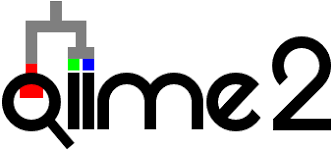

This workflow follows documentation from QIIME2 documents on [tutorials](https://docs.qiime2.org/2017.12/tutorials/) - mainly from the moving pictures tutorial. 
<br>
<br>
***16S amplicon NGS analysis***

This notebook continues on from the notebook on data import & preliminary analysis, and native installation of QIIME2 following the USEARCH pipeline.

An analysis of both the [SILVA](https://www.arb-silva.de/) and [Greengenes databases](http://greengenes.lbl.gov/Download/) (current Jan 2018) found that for tick-microbiome analysis Greengenes allowed for finer resolution of taxonomy and thus is recommended and used here. Both GreenGenes and Silva along with other curated datasets have comparable results overall and it is suggested that for new analysis a comparison is made to determine thebest datasets for your use. Other taxonomy classifer methods can be used such as vsearch and BLAST+, see QIIME2 `feature-classifier` documenation for more information [here](https://docs.qiime2.org/2017.12/plugins/available/feature-classifier/)

# Training Feature Classifier

This workbook will follow instructions detailed by QIIME2 - full  documentation available [here](https://docs.qiime2.org/2017.12/tutorials/feature-classifier/)

This tutorial will demonstrate how to train q2-feature-classifier for a particular dataset. We will train the Naive Bayes classifier using Greengenes reference sequences and classify the representative sequences.

It is recommended you make another file within your `/NGS_analysis` directory

mkdir training-feature-classifiers
cd training-feature-classifiers

Download the Greengenes data set available [here](http://qiime.org/home_static/dataFiles.html).

As at Jan 2018 the latest release is the `13_8(most recent)` dataset available.

This will automatically download. Open the zipped file in your `Finder` or file browser. You will see the following:

    - /otus
    - /rep_set
    - /rep_set_aligned
    - /taxonomy
    - /trees
    - notes

Depending on your analysis you may want to use different classifer thresholds, however for this instance we will use 99% datasets. Particularly if you are following the USEARCH pipeline in this analysis where ZOTUs are >97% similar. 

We recommend copying the relevent files to your current directory. `/training-feature-classifers`. Alternatively you may like to store it in a central file and refer to the full file path when referencing the classifier in the QIIME2 scripts. In theory you should only need to train the classifer once for each set of primers (at each threshold), and therefore you may like to have this ready to train on your new set of sequences.

For the sake of this workbook we will assume it is in your current directory.

Locate the following files and copy & paste them in your current directory `/training-feature-classifiers`.

    /taxonomy/99_otu_taxonomy.txt
    /rep_set_aligned/99_otus.fasta

You will also need to move your sequences.qza file into this directory. We recommend copy & paste this file, to leave the original in the `/7.unoise_all directory` untouched

From the terminal in the QIIME environment a listing command should retrive the following

    ls

    99_otu_taxonomy.txt
    99_otus.fasta
    sequences.qza

Since the Greengenes reference taxonomy file (`85_otu_taxonomy.txt`) is a tab-separated (TSV) file without a header, we must specify `HeaderlessTSVTaxonomyFormat` as the source format since the default *source format* requires a header.

    qiime tools import \
    --type 'FeatureData[Sequence]' \
    --input-path 99_otus.fasta \
    --output-path 99_otus.qza

    qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --source-format HeaderlessTSVTaxonomyFormat \
    --input-path 99_otu_taxonomy.txt \
    --output-path ref-taxonomy.qza

**Output artifacts:**

    99_otus.qza
    ref-taxonomy.qza

# Extract reference reads

It has been shown that taxonomic classification accuracy improves when a Naive Bayes classifier is trained on only the region of the target sequences that was sequenced ([Werner et al., 2012](https://www.ncbi.nlm.nih.gov/pubmed/21716311)). 

For this tutorial we will use the primer set for the V1-2 hypervariable region as outlined by ([Gofton et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26108374))

    qiime feature-classifier extract-reads \
    --i-sequences 99_otus.qza \
    --p-f-primer AGAGTTTGATCCTGGCTYAG \
    --p-r-primer TGCTGCCTCCCGTAGGAGT \
    --p-trunc-len 350 \
    --o-reads ref-seqs.qza

For V3-4 region primer set 515F-806R: ([Caporaso et al. 2011](https://www.ncbi.nlm.nih.gov/pubmed/20534432))

    qiime feature-classifier extract-reads \
    --i-sequences 99_otus.qza \
    --p-f-primer GTGBCAGCMGCCGCGGTAA \
    --p-r-primer GGACTACHVGGGTWTCTAAT \
    --p-trunc-len 350 \
    --o-reads ref-seqs.qza

**Otuput artifact:**

    ref-seqs.qza

# Train the classifier

We can now train a [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier as follows, using the reference reads and taxonomy that we just created.

    qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads ref-seqs.qza \
    --i-reference-taxonomy ref-taxonomy.qza \
    --o-classifier classifier.qza

**Otuput artifact:**

    classifier.qza

# Test the classifier

Finally, we verify that the classifier works by classifying the representative sequences from the Moving Pictures tutorial and visualizing the resulting taxonomic assignments.

    qiime feature-classifier classify-sklearn \
    --i-classifier classifier.qza \
    --i-reads sequences.qza \
    --o-classification taxonomy.qza

    qiime metadata tabulate \
    --m-input-file taxonomy.qza \
    --o-visualization taxonomy.qzv

**Output artifacts:**

    taxonomy.qza

**Output visualizations:**

    taxonomy.qzv

<div class="alert alert-block alert-success">**Question**<br></br>

Recall that our `sequences.qzv` visualization allows you to easily BLAST the sequence associated with each feature against the NCBI nt database. Using that visualization and the `taxonomy.qzv` visualization created here, compare the taxonomic assignments with the taxonomy of the best BLAST hit for a few features. How similar are the assignments? If they’re dissimilar, at what taxonomic level do they begin to differ (e.g., species, genus, family, ...)?</div>

Next, we can view the taxonomic composition of our samples with interactive bar plots. Generate those plots with the following command and then open the visualization.

    qiime taxa barplot \
    --i-table feature-table-1.qza \
    --i-taxonomy taxonomy.qza \
    --m-metadata-file metadata.tsv \
    --o-visualization taxa-bar-plots.qzv